# Visualiser

In [5]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
### HELPER FUNCTIONS
from mlp.errors import CrossEntropyLogSoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import *
from mlp.learning_rules import *
from mlp.optimisers import Optimiser

import matplotlib.pyplot as plt
plt.style.use('ggplot')


def train_model_and_plot_stats(model,
                               error,
                               learning_rule,
                               train_data,
                               valid_data,
                               test_data,
                               num_epochs,
                               stats_interval,
                               notebook=False,
                               displayGraphs=False):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        test_data,
        data_monitors,
        notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(
        num_epochs=num_epochs, stats_interval=stats_interval)

    if displayGraphs:
        # Plot the change in the validation and training set error over training.
        fig_1 = plt.figure(figsize=(8, 4))
        ax_1 = fig_1.add_subplot(111)
        for k in ['error(train)', 'error(valid)']:
            ax_1.plot(
                np.arange(1, stats.shape[0]) * stats_interval,
                stats[1:, keys[k]],
                label=k)
        ax_1.legend(loc=0)
        ax_1.set_xlabel('Epoch number')

        # Plot the change in the validation and training set accuracy over training.
        fig_2 = plt.figure(figsize=(8, 4))
        ax_2 = fig_2.add_subplot(111)
        for k in ['acc(train)', 'acc(valid)']:
            ax_2.plot(
                np.arange(1, stats.shape[0]) * stats_interval,
                stats[1:, keys[k]],
                label=k)
        ax_2.legend(loc=0)
        ax_2.set_xlabel('Epoch number')

        return optimiser.model, stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
    else:
        return optimiser.model, stats, keys, run_time
    
    
def analyse_mean_std(data):
    """
    Find the best mean
    """
    best_epochs = {}
    for i in data.keys():
        # each parameter's validation and training result
        _data = data[i]
        # plot the accuracy for each layer
        _tr_acc = _data['train_acc']
        _tr_err = _data['train_err']
        _val_acc = _data['val_acc']
        _val_err = _data['val_err']
        _test_acc = _data['test_acc']
        best_epoch = np.argmax(_val_acc['mean'])
        best_epochs[i] = {'idx': best_epoch,
                       'mean': _val_acc['mean'][best_epoch],
                       'std':  _val_acc['std'][best_epoch],
                         'test_acc_mean': _test_acc['mean'][best_epoch],
                         'test_acc_std': _test_acc['std'][best_epoch]}
    return best_epochs

def generate_mean_std(stats):
    """
    stats ia dictionary of:
    keys : parameters being varied
    values: dataset
    """
    out = {}
    for param in stats.keys():
        # Iterate each parameter to generate stats for each and every epoch:
        data = stats[param]
        out[param] = {}
        for _param in data.keys():
            # this corresponds to the val_err/val_acc/train_acc/train_err:
            _data = data[_param] # This data is for each trial!
            _data_paded = numpy_fillna(_data)
            mean = np.nanmean(_data_paded, axis=0)
            std = np.nanstd(_data_paded, axis=0)
            out[param][_param] = {'mean': mean,
                                  'std' : std}
    return out

def numpy_fillna(data):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.empty(mask.shape)
    out[:] = np.nan
    out[mask] = np.concatenate(np.array(data))
    return out

In [23]:
import pickle as pkl
import numpy as np
from pprint import pprint
from mlp.artist import plot_param_histogram, show_batch_of_images, visualise_first_layer_weights
from mlp.helper import analyse_mean_std, generate_mean_std, train_model_and_plot_stats

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Varying number of layers (for different activation function)

Hypothesis 1: There is a difference in validation accuracy when the number of hidden layers increases from 2 to 10.

Hypothesis 2: For the same number of layers, different activation functions will vary the results.



***Experiment Parameters:***
    
    Number of trials: range(1,4)
    layers_depth = [1,3,5,7] == [2,4,6,8]
    funcs = {'sigmoid':SigmoidLayer(), 
             'relu':ReluLayer(), 
             'elu':ELULayer(), 
             'selu':SELULayer()}
    num_epochs = 60
    num_hidden_unit = 100
    SGD(learningrule =  0.01)
    Early stopping = NO
    

    NOTE THE DIFFERENCES IN THE MODELS::::::!!!!!! 02 series have 7 tuple

In [60]:
model, stats, keys, run_time = pkl.load(
    open("01_02_ActFunc_Layers/actfunc_expt_t0_d1_relu.pkl", 'rb'))

In [63]:
stats, keys, run_time, fig1, ax1, fig2, ax2 = pkl.load(
    open("01_02_ActFunc_Layers/actfunc_expt_t2_d7_sigmoid.pkl", 'rb'))

In [62]:
from collections import OrderedDict

In [96]:
# Group the output by activation function:
models_sigmoid = OrderedDict()
models_elu = OrderedDict()
models_selu = OrderedDict()
models_relu = OrderedDict()

sigmoid = {}
relu = {}
elu = {}
selu = {}
layers_depth = [1, 3, 5, 7]  # +1 to each for the total number of layers:

for func, store in {
        'relu': relu,
        'elu': elu,
        'sigmoid': sigmoid,
        'selu': selu
}.items():
    for layers in layers_depth:
        store[layers+1] = {}
        store[layers+1]['val_err'] = []
        store[layers+1]['val_acc'] = []
        store[layers+1]['train_err'] = []
        store[layers+1]['train_acc'] = []
        store[layers+1]['test_acc'] = []
        
        for trials in range(3):
            print(trials, layers,func)
            title = "01_02_ActFunc_Layers/actfunc_expt_t{}_d{}_{}.pkl".format(trials, layers, func)
            try:
                model, stats, keys, run_time = pkl.load(open(title, 'rb'))
            except ValueError:
                stats,keys,run_time,_,_,_,_ = pkl.load(open(title, 'rb'))

            # Store the model:
            store[layers+1]['val_err'].append(stats[1:, keys['error(valid)']])
            store[layers+1]['val_acc'].append(stats[1:, keys['acc(valid)']])
            store[layers+1]['train_err'].append(stats[1:, keys['error(train)']])
            store[layers+1]['train_acc'].append(stats[1:, keys['acc(train)']])
            store[layers+1]['test_acc'].append(stats[1:, keys['acc(test)']])
            

0 1 relu
1 1 relu
2 1 relu
0 3 relu
1 3 relu
2 3 relu
0 5 relu
1 5 relu
2 5 relu
0 7 relu
1 7 relu
2 7 relu
0 1 elu
1 1 elu
2 1 elu
0 3 elu
1 3 elu
2 3 elu
0 5 elu
1 5 elu
2 5 elu
0 7 elu
1 7 elu
2 7 elu
0 1 sigmoid
1 1 sigmoid
2 1 sigmoid
0 3 sigmoid
1 3 sigmoid
2 3 sigmoid
0 5 sigmoid
1 5 sigmoid
2 5 sigmoid
0 7 sigmoid
1 7 sigmoid
2 7 sigmoid
0 1 selu
1 1 selu
2 1 selu
0 3 selu
1 3 selu
2 3 selu
0 5 selu
1 5 selu
2 5 selu
0 7 selu
1 7 selu
2 7 selu


In [97]:
# Store model for later:
for func, store in {
    'relu': models_relu,
    'elu': models_elu,
    'selu': models_selu,
    'sigmoid': models_sigmoid
}.items():
    for layers in layers_depth:
        for trials in range(2):
            print(trials, layers,func)
            title = "01_02_ActFunc_Layers/actfunc_expt_t{}_d{}_{}.pkl".format(trials, layers, func)
            model, _, _, _ = pkl.load(open(title, 'rb'))
            store[layers+1] = model

0 1 relu
1 1 relu
0 3 relu
1 3 relu
0 5 relu
1 5 relu
0 7 relu
1 7 relu
0 1 elu
1 1 elu
0 3 elu
1 3 elu
0 5 elu
1 5 elu
0 7 elu
1 7 elu
0 1 selu
1 1 selu
0 3 selu
1 3 selu
0 5 selu
1 5 selu
0 7 selu
1 7 selu
0 1 sigmoid
1 1 sigmoid
0 3 sigmoid
1 3 sigmoid
0 5 sigmoid
1 5 sigmoid
0 7 sigmoid
1 7 sigmoid


### Sigmoid Activation Function:

In [98]:
mu_rho_sigmoid = generate_mean_std(sigmoid)
best_epochs_sigmoid = analyse_mean_std(mu_rho_sigmoid)

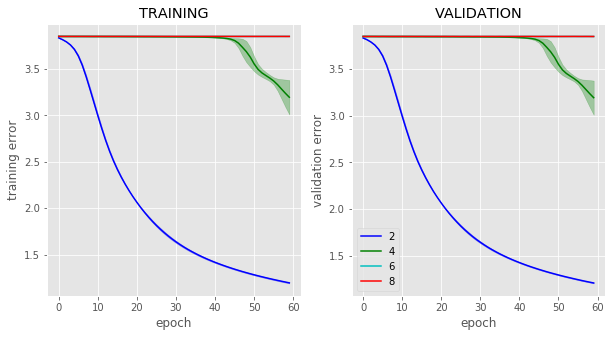

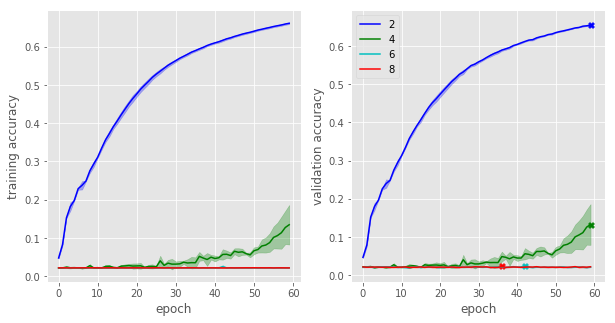

In [99]:
fig1_sigmoid,fig2_sigmoid, ax11_sigmoid,ax12_sigmoid,ax21_sigmoid,ax22_sigmoid =\
    plot_graph_mean_std(mu_rho_sigmoid, best_epochs_sigmoid)

In [100]:
pprint(best_epochs_sigmoid)

{2: {'idx': 59,
     'mean': 0.65497890295358652,
     'std': 0.001581293645691423,
     'test_acc_mean': 0.64789029535865017,
     'test_acc_std': 0.0018498152081672656},
 4: {'idx': 59,
     'mean': 0.13257383966244729,
     'std': 0.053502400869710504,
     'test_acc_mean': 0.13040084388185649,
     'test_acc_std': 0.049951488866777874},
 6: {'idx': 42,
     'mean': 0.024135021097046381,
     'std': 0.0043868668904462572,
     'test_acc_mean': 0.024029535864978871,
     'test_acc_std': 0.0053240686233881557},
 8: {'idx': 36,
     'mean': 0.022616033755274229,
     'std': 0.00032819302080388521,
     'test_acc_mean': 0.020316455696202506,
     'test_acc_std': 0.0015216221873634557}}


### ReLU Activation function

In [101]:
mu_rho_relu = generate_mean_std(relu)
best_epochs_relu = analyse_mean_std(mu_rho_relu)

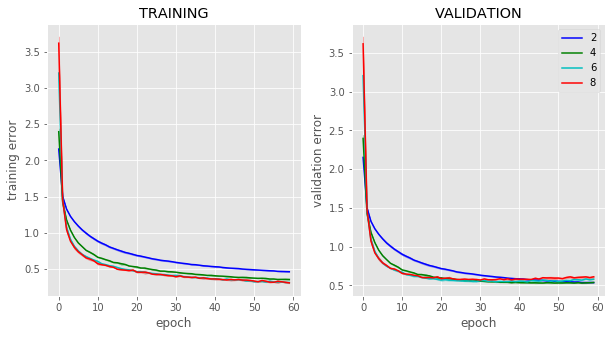

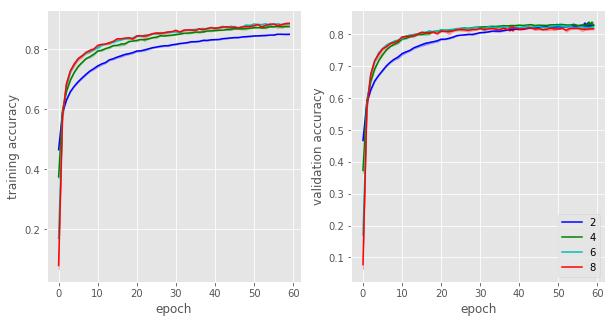

In [102]:
fig1_relu,fig2_relu, ax11_relu,ax12_relu,ax21_relu,ax22_relu =\
    plot_graph_mean_std(mu_rho_relu, best_epochs_relu)

In [103]:
pprint(best_epochs_relu)

{2: {'idx': 57,
     'mean': 0.82805907172995763,
     'std': 0.00090741827711404678,
     'test_acc_mean': 0.81573839662447245,
     'test_acc_std': 0.00097275458931629622},
 4: {'idx': 58,
     'mean': 0.83154008438818527,
     'std': 0.00058769570789780846,
     'test_acc_mean': 0.82080168776371287,
     'test_acc_std': 0.0014764918318080048},
 6: {'idx': 50,
     'mean': 0.82651898734177198,
     'std': 0.0042522979828453836,
     'test_acc_mean': 0.8165822784810125,
     'test_acc_std': 0.0029474016014778733},
 8: {'idx': 38,
     'mean': 0.82035864978902928,
     'std': 0.0031798505273034424,
     'test_acc_mean': 0.80852320675105493,
     'test_acc_std': 0.0011833167647577907}}


### ELU Activation Function

In [104]:
mu_rho_elu = generate_mean_std(elu)
best_epochs_elu = analyse_mean_std(mu_rho_elu)

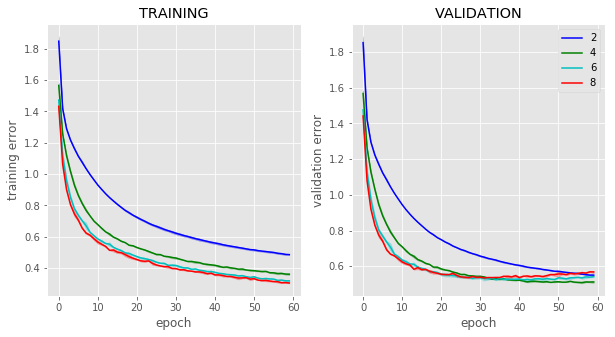

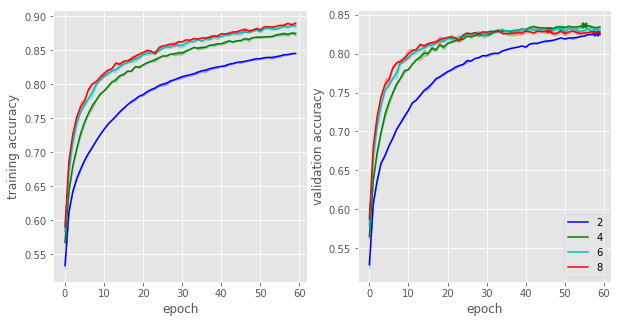

In [105]:
fig1_elu, fig2_elu, ax11_elu, ax12_elu, ax21_elu, ax22_elu = plot_graph_mean_std(
    mu_rho_elu, best_epochs_elu)

In [106]:
pprint(best_epochs_elu)

{2: {'idx': 58,
     'mean': 0.82647679324894474,
     'std': 0.00014917864581973818,
     'test_acc_mean': 0.81375527426160321,
     'test_acc_std': 0.0026255441664313176},
 4: {'idx': 55,
     'mean': 0.83639240506329093,
     'std': 0.0010166062281143932,
     'test_acc_mean': 0.82565400843881853,
     'test_acc_std': 0.00041770020829607816},
 6: {'idx': 49,
     'mean': 0.83270042194092786,
     'std': 0.0016906620683248303,
     'test_acc_mean': 0.8244303797468352,
     'test_acc_std': 0.0017592963493154156},
 8: {'idx': 46,
     'mean': 0.83018987341772144,
     'std': 0.0027679775132697874,
     'test_acc_mean': 0.81875527426160311,
     'test_acc_std': 0.001687499979394049}}


### SELU Activation Function

In [108]:
mu_rho_selu = generate_mean_std(selu)
best_epochs_selu = analyse_mean_std(mu_rho_selu)

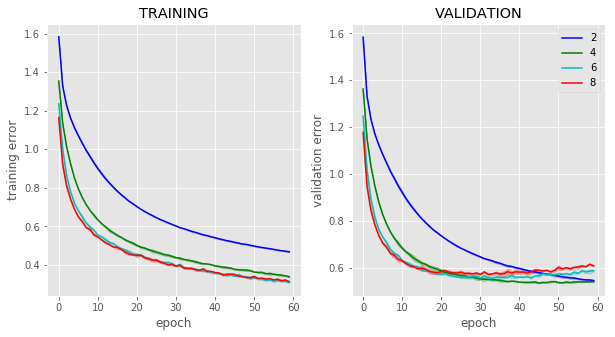

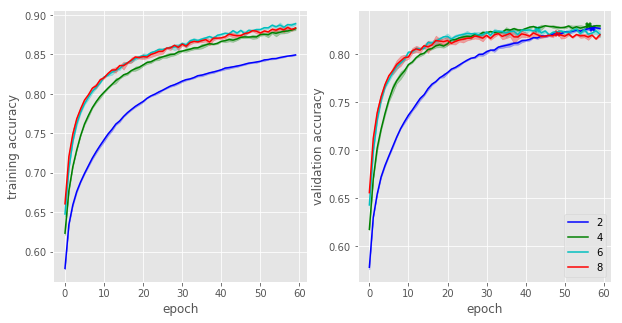

In [109]:
fig1_selu, fig2_selu, ax11_selu, ax12_selu, ax21_selu, ax22_selu = plot_graph_mean_std(
    mu_rho_selu, best_epochs_selu)

In [110]:
pprint(best_epochs_selu)

{2: {'idx': 57,
     'mean': 0.82719409282700418,
     'std': 0.0010966406260225598,
     'test_acc_mean': 0.81348101265822736,
     'test_acc_std': 0.00013672448730816288},
 4: {'idx': 56,
     'mean': 0.82966244725738425,
     'std': 0.0016635927429296364,
     'test_acc_mean': 0.82078059071729914,
     'test_acc_std': 0.0013419446323872225},
 6: {'idx': 43,
     'mean': 0.82582278481012661,
     'std': 0.0031776102096127221,
     'test_acc_mean': 0.81559071729957788,
     'test_acc_std': 0.00091035649832855038},
 8: {'idx': 48,
     'mean': 0.8221097046413498,
     'std': 0.00013005092833261108,
     'test_acc_mean': 0.81147679324894506,
     'test_acc_std': 0.0027628271843264992}}


BEST AT FOUR HIDDEN LAYERS

## Comparing activation function's performance at fixed depth

In [111]:
two = {}
four = {}
six = {}
eight = {}

In [119]:
for depth, store in {2:two, 4:four, 6:six, 8:eight}.items():
    for func, data in {
            'relu': mu_rho_relu,
            'elu': mu_rho_elu,
            'sigmoid': mu_rho_sigmoid,
            'selu': mu_rho_selu
    }.items():
        store[func] = data[int(depth)]

### 2 hidden layers

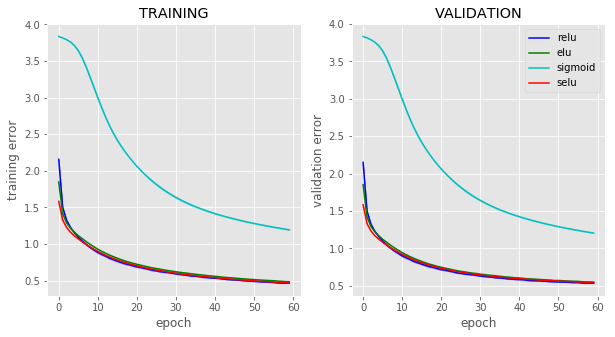

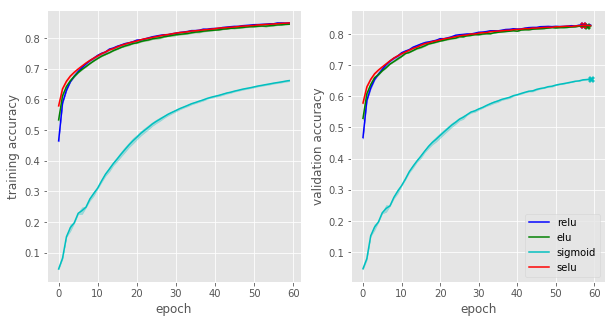

In [128]:
best_epoch_two = analyse_mean_std(two)
fig1_two, fig2_two, ax11_two, ax12_two, ax21_two, ax22_two = plot_graph_mean_std(
    two, best_epoch_two)

In [135]:
pprint(best_epoch_two)

{'elu': {'idx': 58,
         'mean': 0.82647679324894474,
         'std': 0.00014917864581973818,
         'test_acc_mean': 0.81375527426160321,
         'test_acc_std': 0.0026255441664313176},
 'relu': {'idx': 57,
          'mean': 0.82805907172995763,
          'std': 0.00090741827711404678,
          'test_acc_mean': 0.81573839662447245,
          'test_acc_std': 0.00097275458931629622},
 'selu': {'idx': 57,
          'mean': 0.82719409282700418,
          'std': 0.0010966406260225598,
          'test_acc_mean': 0.81348101265822736,
          'test_acc_std': 0.00013672448730816288},
 'sigmoid': {'idx': 59,
             'mean': 0.65497890295358652,
             'std': 0.001581293645691423,
             'test_acc_mean': 0.64789029535865017,
             'test_acc_std': 0.0018498152081672656}}


### 4 hidden layers

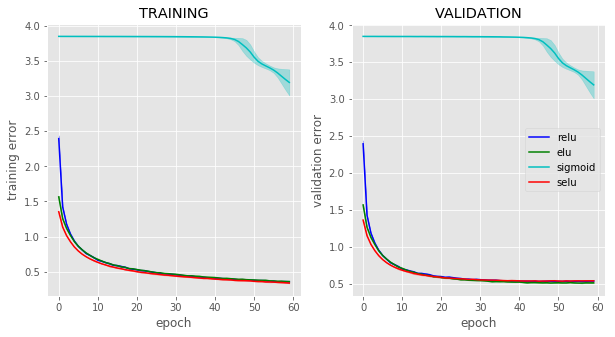

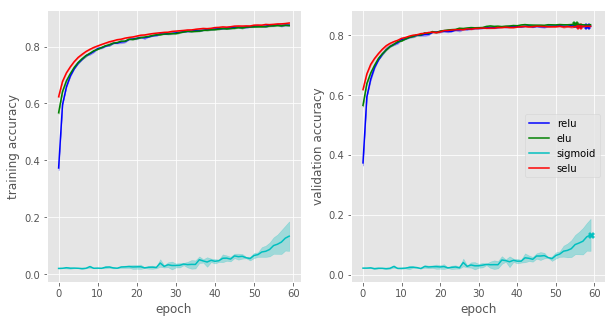

In [129]:
best_epoch_four = analyse_mean_std(four)
fig1_four, fig2_four, ax11_four, ax12_four, ax21_four, ax22_four = plot_graph_mean_std(
    four, best_epoch_four)

In [134]:
pprint(best_epoch_four)

{'elu': {'idx': 55,
         'mean': 0.83639240506329093,
         'std': 0.0010166062281143932,
         'test_acc_mean': 0.82565400843881853,
         'test_acc_std': 0.00041770020829607816},
 'relu': {'idx': 58,
          'mean': 0.83154008438818527,
          'std': 0.00058769570789780846,
          'test_acc_mean': 0.82080168776371287,
          'test_acc_std': 0.0014764918318080048},
 'selu': {'idx': 56,
          'mean': 0.82966244725738425,
          'std': 0.0016635927429296364,
          'test_acc_mean': 0.82078059071729914,
          'test_acc_std': 0.0013419446323872225},
 'sigmoid': {'idx': 59,
             'mean': 0.13257383966244729,
             'std': 0.053502400869710504,
             'test_acc_mean': 0.13040084388185649,
             'test_acc_std': 0.049951488866777874}}


### 6 hidden layers

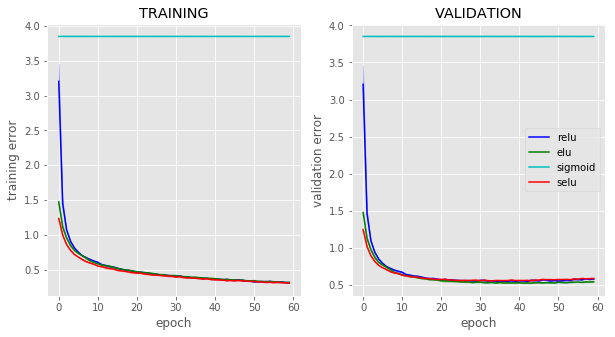

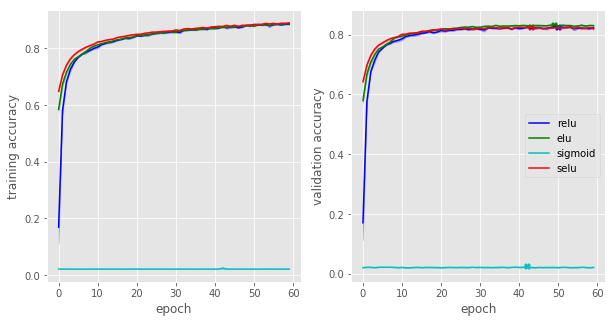

In [130]:
best_epoch_six = analyse_mean_std(six)
fig1_six, fig2_six, ax11_six, ax12_six, ax21_six, ax22_six = plot_graph_mean_std(
    six, best_epoch_six)

In [132]:
pprint(best_epoch_six)

{'elu': {'idx': 49,
         'mean': 0.83270042194092786,
         'std': 0.0016906620683248303,
         'test_acc_mean': 0.8244303797468352,
         'test_acc_std': 0.0017592963493154156},
 'relu': {'idx': 50,
          'mean': 0.82651898734177198,
          'std': 0.0042522979828453836,
          'test_acc_mean': 0.8165822784810125,
          'test_acc_std': 0.0029474016014778733},
 'selu': {'idx': 43,
          'mean': 0.82582278481012661,
          'std': 0.0031776102096127221,
          'test_acc_mean': 0.81559071729957788,
          'test_acc_std': 0.00091035649832855038},
 'sigmoid': {'idx': 42,
             'mean': 0.024135021097046381,
             'std': 0.0043868668904462572,
             'test_acc_mean': 0.024029535864978871,
             'test_acc_std': 0.0053240686233881557}}


### 8 hidden layers

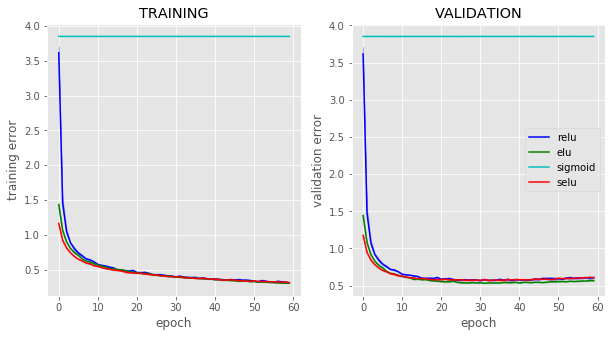

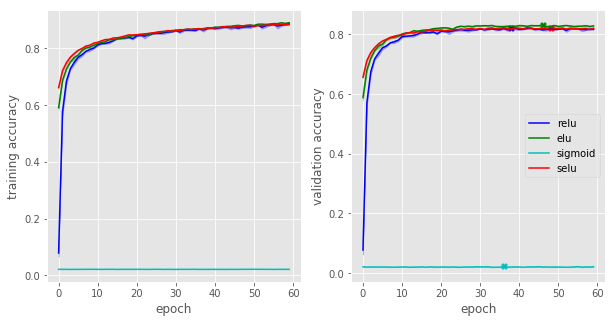

In [131]:
best_epoch_eight = analyse_mean_std(eight)
fig1_eight, fig2_eight, ax11_eight, ax12_eight, ax21_eight, ax22_eight = plot_graph_mean_std(
    eight, best_epoch_eight)

In [133]:
pprint(best_epoch_eight)

{'elu': {'idx': 46,
         'mean': 0.83018987341772144,
         'std': 0.0027679775132697874,
         'test_acc_mean': 0.81875527426160311,
         'test_acc_std': 0.001687499979394049},
 'relu': {'idx': 38,
          'mean': 0.82035864978902928,
          'std': 0.0031798505273034424,
          'test_acc_mean': 0.80852320675105493,
          'test_acc_std': 0.0011833167647577907},
 'selu': {'idx': 48,
          'mean': 0.8221097046413498,
          'std': 0.00013005092833261108,
          'test_acc_mean': 0.81147679324894506,
          'test_acc_std': 0.0027628271843264992},
 'sigmoid': {'idx': 36,
             'mean': 0.022616033755274229,
             'std': 0.00032819302080388521,
             'test_acc_mean': 0.020316455696202506,
             'test_acc_std': 0.0015216221873634557}}


## Experiment: Number of hidden units

In this experiment, we use our best-performing activation function (in the previous experiment) - 4 hidden layers with ELU layer - to find the optimum number of hidden unit.

I use the same experiment setup as before, varying the number of hidden nodes:[100, 200, 400, 500].

In [137]:
expt_data = {}
for i in range(1,4):
    name = './NumHiddenUnitsExpt/experiment_units_elu_4layer_{}.pkl'.format(i)
    expt_data[i] = pkl.load(open(name, 'rb'))

In [139]:
hidden_units = [100, 200, 400, 500]
hidden_units_stats = {a: dict() for a in hidden_units}

# Iterate through each of the test stats:
for i in range(1, 4):
    _expt_data = expt_data[i]

    # Iterate through each hidden layer experiment:
    for num_units in _expt_data.keys():
        model, stats, keys, run_time = expt_data[i][num_units]
        if i == 1:
            hidden_units_stats[num_units]['val_err'] = []
            hidden_units_stats[num_units]['val_acc'] = []
            hidden_units_stats[num_units]['train_err'] = []
            hidden_units_stats[num_units]['train_acc'] = []
            hidden_units_stats[num_units]['test_acc'] = []
        hidden_units_stats[num_units]['val_err'].append(
            stats[1:, keys['error(valid)']])
        hidden_units_stats[num_units]['val_acc'].append(
            stats[1:, keys['acc(valid)']])
        hidden_units_stats[num_units]['train_err'].append(
            stats[1:, keys['error(train)']])
        hidden_units_stats[num_units]['train_acc'].append(
            stats[1:, keys['acc(train)']])
        hidden_units_stats[num_units]['test_acc'].append(
            stats[1:, keys['acc(test)']])

In [140]:
hidden_units_stats_mu_rho = generate_mean_std(hidden_units_stats)
best_epochs = analyse_mean_std(hidden_units_stats_mu_rho)

In [141]:
pprint(best_epochs)

{100: {'idx': 66,
       'mean': 0.83943037974683532,
       'std': 0.0013366273469582865,
       'test_acc_mean': 0.82698312236286908,
       'test_acc_std': 0.0012974254735460824},
 200: {'idx': 74,
       'mean': 0.84740506329113907,
       'std': 0.00096540600748067909,
       'test_acc_mean': 0.83708860759493653,
       'test_acc_std': 0.0013426078123795801},
 400: {'idx': 61,
       'mean': 0.85308016877637138,
       'std': 0.0012682817185813143,
       'test_acc_mean': 0.84213080168776366,
       'test_acc_std': 0.0014628637825622054},
 500: {'idx': 72,
       'mean': 0.85424050632911397,
       'std': 0.0018086949577512433,
       'test_acc_mean': 0.84402953586497897,
       'test_acc_std': 0.0013117545617476153}}


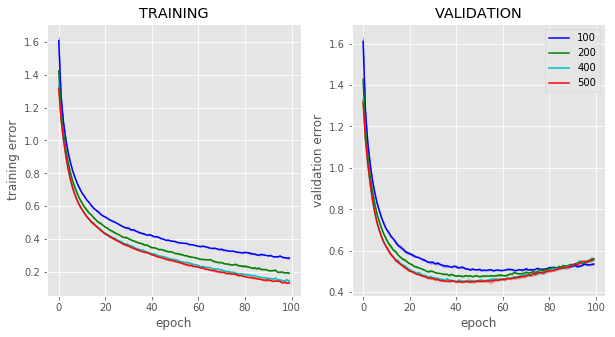

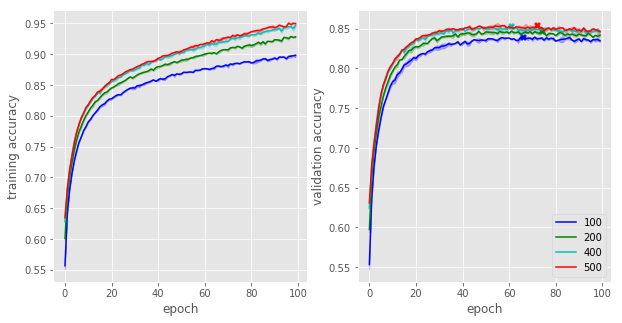

In [142]:
fig1, fig2, ax11, ax12, ax21, ax22 = plot_graph_mean_std(
    hidden_units_stats_mu_rho, best_epochs)

Choose 400 hidden units, as faster convergence; marginal improvement from 500.

### Visualising the activation function at each hidden layer

    OUR BASELINE MODEL
    ELU
    4 HIDDEN LAYER
    400 UNITS EACH

## Initialisation methods

Using He Init [] instead of Glorot - any better performance?

# Learning Rule

We explore the difference between 

# Regularisers

## L1/L2 Regulariser